# Introduction

Hi! My name is [Terenci Claramunt](https://www.linkedin.com/in/terenci/), and I'm a senior Data Science student. I wrote this notebook to showcase some of the capabilities of SQL for data analysis. The goal is to perform all data manipulation using only SQL, and use python only to visualize the results.

The data I'll analyze comes from [Olist](https://olist.com/), a Brazilian e-commerce platform that connects small businesses to larger product marketplaces. Olist published a dataset containing 99441 orders from March 2016 to August 2018. The data is anonymized, so it doesn't contain names for buyers, sellers or products. I imported the original CSV files into an SQLite database with the following schema:

![SQLite database schema](https://terencicp.github.io/public/db-schema.png)

Data source: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

Throughout this notebook I'll introduce you to each of these tables and we'll explore some of their fields. Have a look at the Table of Contents to see all the topics we'll cover. If you find this notebook useful, please upvote it to help others discover it.

## Connecting to the database

SQLite is simpler than other databases such as PostgreSQL or MySQL. The entire database is contained in a single file, and it doesn't require a dedicated server running on the background. The `sqlite3` library allows us to query the database using python:

In [1]:
import sqlite3

db_path = '/kaggle/input/e-commerce-dataset-by-olist-as-an-sqlite-database/olist.sqlite'
db_connection = sqlite3.connect(db_path)

To query the database we just need to write an SQL query as a string and pass it to `pandas.read_sql_query` along with the database connection, which will return a pandas dataframe containing the query result.

Throughout this notebook we'll use the following function to explore the tables in the database using a concise syntax:

In [2]:
import pandas as pd

def view_table(table, limit):
    query = f"""
        SELECT *
        FROM {table}
        LIMIT {limit}
    """
    return pd.read_sql_query(query, db_connection)

If you want to play around with this data you can download the database file from the Kaggle dataset:

https://www.kaggle.com/datasets/terencicp/e-commerce-dataset-by-olist-as-an-sqlite-database

I also created a GitHub repository that contains all the SQL queries used on this notebook as .sql files:

https://github.com/terencicp/sql-challenge

<br>

# Number of orders

The **orders** table contains IDs for order and customer and delivery status, which can be 'delivered' or take other values before the order is delivered:

In [3]:
# Table orders, first 3 columns
view_table('orders', 5).iloc[:, :3]

,order_id,customer_id,order_status
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered


The next columns contain the timestamps that mark order status changes and an estimated delivery date at the last column:

In [4]:
# Table orders, timestamp columns
view_table('orders', 5).iloc[:, 3:]

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Let's count the number of daily orders in the dataset using an SQL **GROUP BY** clause on the order timestamp and view the first 5 resulting rows:

In [5]:
orders_per_day = """
SELECT
    DATE(order_purchase_timestamp) AS day,
    COUNT(*) AS order_count
FROM orders
GROUP BY day
"""

df = pd.read_sql_query(orders_per_day, db_connection)
df.head(5)

,day,order_count
0,2016-09-04,1
1,2016-09-05,1
2,2016-09-13,1
3,2016-09-15,1
4,2016-10-02,1


In the previous output, we can see that the first days contain very few orders. Let's use `matplotlib` to visualize the frequency of orders per day: 

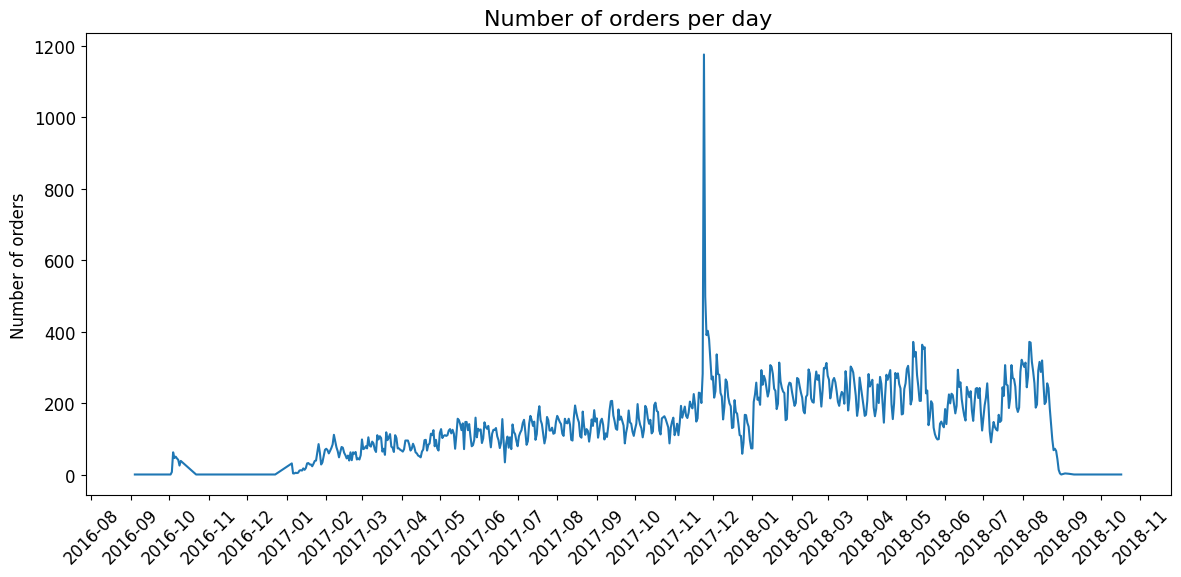

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Increase the default font size globally
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16

# Line plot
plt.figure(figsize=(14, 6))
plt.plot(pd.to_datetime(df['day']), df['order_count'])
plt.ylabel('Number of orders')
plt.title('Number of orders per day')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.show()

We can see there's a large spike of orders around Christmas, specifically on the 24th of december. The number of orders also seems to be increasing steadily over time as Olist's business grows. Also notice how there's very few data at the start and end of the timespan covered by the dataset, so we'll exclude these dates from some of our next queries.

How are orders distributed over the week? Are more orders placed on weekends? How about during the day? Do customers place more orders in the evening? We can answer these questions using a heatmap that plots the distribution of both on a grid. To plot a heatmap we need a matrix of counts of orders, where rows represent days of the week and columns represent hours of the day. Let's first extract the day of the week and the hour of the day from each order timestamp using the function STRFTIME:

In [7]:
order_day_hour = """
SELECT
    -- Day of the week abreviated
    CASE STRFTIME('%w', order_purchase_timestamp)
        WHEN '1' THEN 'Mon'
        WHEN '2' THEN 'Tue'
        WHEN '3' THEN 'Wed'
        WHEN '4' THEN 'Thu'
        WHEN '5' THEN 'Fri'
        WHEN '6' THEN 'Sat'
        WHEN '0' THEN 'Sun'
        END AS day_of_week_name,
    -- Day of the week as integer (Sunday=7)
    CAST(STRFTIME('%w', order_purchase_timestamp) AS INTEGER) AS day_of_week_int,
    -- Hour of the day (0-24)
    CAST(STRFTIME("%H", order_purchase_timestamp) AS INTEGER) AS hour
FROM orders
"""

pd.read_sql_query(order_day_hour, db_connection)

,day_of_week_name,day_of_week_int,hour
0,Mon,1,10
1,Tue,2,20
2,Wed,3,8
3,Sat,6,19
4,Tue,2,21
...,...,...,...
99436,Thu,4,9
99437,Tue,2,12
99438,Sun,0,14
99439,Mon,1,21


To efficiently generate a column of the count of orders for each hour of the day in an SQL query, we can use a Python list comprehension. This approach allows us to avoid writing 24 repetitive statements. We'll also use the previous query as a CTE.

In [8]:
count_orders_per_hour = ',\n    '.join([
    f'COUNT(CASE WHEN hour = {i} THEN 1 END) AS "{i}"' \
    for i in range(24)
])

orders_per_day_of_the_week_and_hour = f"""
WITH OrderDayHour AS (
    {order_day_hour}
)
SELECT
    day_of_week_name,
    {count_orders_per_hour}
FROM OrderDayHour
GROUP BY day_of_week_int
ORDER BY day_of_week_int
"""

Let's have a look at the code generated in the main query:

In [9]:
# SQL query without the CTE
print(orders_per_day_of_the_week_and_hour[591:])

SELECT
    day_of_week_name,
    COUNT(CASE WHEN hour = 0 THEN 1 END) AS "0",
    COUNT(CASE WHEN hour = 1 THEN 1 END) AS "1",
    COUNT(CASE WHEN hour = 2 THEN 1 END) AS "2",
    COUNT(CASE WHEN hour = 3 THEN 1 END) AS "3",
    COUNT(CASE WHEN hour = 4 THEN 1 END) AS "4",
    COUNT(CASE WHEN hour = 5 THEN 1 END) AS "5",
    COUNT(CASE WHEN hour = 6 THEN 1 END) AS "6",
    COUNT(CASE WHEN hour = 7 THEN 1 END) AS "7",
    COUNT(CASE WHEN hour = 8 THEN 1 END) AS "8",
    COUNT(CASE WHEN hour = 9 THEN 1 END) AS "9",
    COUNT(CASE WHEN hour = 10 THEN 1 END) AS "10",
    COUNT(CASE WHEN hour = 11 THEN 1 END) AS "11",
    COUNT(CASE WHEN hour = 12 THEN 1 END) AS "12",
    COUNT(CASE WHEN hour = 13 THEN 1 END) AS "13",
    COUNT(CASE WHEN hour = 14 THEN 1 END) AS "14",
    COUNT(CASE WHEN hour = 15 THEN 1 END) AS "15",
    COUNT(CASE WHEN hour = 16 THEN 1 END) AS "16",
    COUNT(CASE WHEN hour = 17 THEN 1 END) AS "17",
    COUNT(CASE WHEN hour = 18 THEN 1 END) AS "18",
    COUNT(CASE WHEN ho

After executing the query, we just need to set the *day_of_the_week_name* column as the dataframe index to get the matrix we need to build the heatmap:

In [10]:
df = pd.read_sql_query(orders_per_day_of_the_week_and_hour, db_connection)
df = df.set_index('day_of_week_name')
df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day_of_week_name,,,,,,,,,,,,,,,,,,,,,
Sun,267,141,69,44,27,27,34,105,205,349,...,684,716,712,797,895,899,967,889,873,607
Mon,328,134,66,36,21,22,69,160,479,783,...,1096,1079,1094,992,928,945,1027,1118,991,717
Tue,306,158,80,28,29,24,71,223,522,864,...,1124,1047,1081,967,877,924,988,1027,965,692
Wed,397,179,81,33,33,27,93,211,517,829,...,1050,983,1040,967,852,848,904,963,878,615
Thu,355,167,75,39,31,28,85,220,502,758,...,977,928,1077,909,784,826,839,840,857,551
Fri,426,216,72,49,40,36,97,206,493,768,...,961,979,974,817,723,784,738,726,702,512
Sat,315,175,67,43,25,24,53,106,249,434,...,677,722,697,701,710,756,730,654,550,429


With the data matrix ready, we can use `seaborn` to create the heatmap:

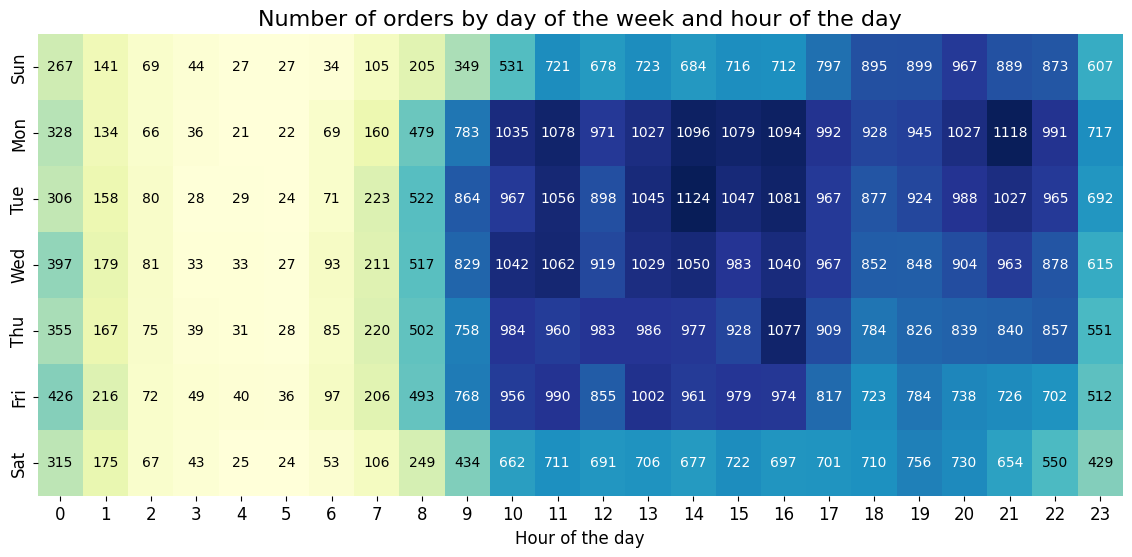

In [11]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(df, cmap='YlGnBu', cbar=False)
mean_orders = df.mean().mean()
for i in range(len(df)):
    for j in range(len(df.columns)):
        text_color = 'white' if df.iloc[i, j] > mean_orders else 'black'
        ax.text(j+0.5, i+0.5, int(df.iloc[i, j]),
            color=text_color, fontsize=10, ha="center", va="center")
plt.title("Number of orders by day of the week and hour of the day")
plt.xlabel("Hour of the day")
plt.ylabel("")
plt.show()

We can observe that most orders were placed during the weekdays from 10 AM to 4 PM with a small dip in sales around 12 PM due to lunchtime. Customers also order through Olist in the evenings around 9 PM from Sunday to Thursday. Saturday is the day with the fewest orders, although it's still quite busy. The least busy time of the day is from 3 to 5 AM, although there are still a few orders during that time.

Now we have examined the distribution of orders through time, we can have a look at the geographic distribution. The table **customers** contains the zip code prefix, city and state for each customer. Also notice there are two customer ids, *customer_unique_id* is the one that identififies each individual customer:

In [12]:
view_table('customers', 5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


What are the cities with the most orders in the dataset? Let's build the query for the top 10 cities and view the result. We'll join the **orders** table to the **customers** table:

In [13]:
orders_per_city = """
SELECT 
    customer_city AS customer_city,
    UPPER(customer_city) AS city,
    COUNT(orders.order_id) as city_order_count
FROM 
    customers
    JOIN orders USING (customer_id)
GROUP BY customer_city
ORDER BY city_order_count DESC
LIMIT 10
"""

pd.read_sql_query(orders_per_city, db_connection)

,customer_city,city,city_order_count
0,sao paulo,SAO PAULO,15540
1,rio de janeiro,RIO DE JANEIRO,6882
2,belo horizonte,BELO HORIZONTE,2773
3,brasilia,BRASILIA,2131
4,curitiba,CURITIBA,1521
5,campinas,CAMPINAS,1444
6,porto alegre,PORTO ALEGRE,1379
7,salvador,SALVADOR,1245
8,guarulhos,GUARULHOS,1189
9,sao bernardo do campo,SAO BERNARDO DO CAMPO,938


Let's plot them using a bar plot. The `barh` function of `matplotlib` plots data from bottom to top, so we'll need to reverse it first. To achieve this using SQL, I'll use the previous query as a subquery to reverse the order of the results:

In [14]:
orders_per_city_reversed = f"""
SELECT *
FROM ({orders_per_city})
ORDER BY city_order_count
"""

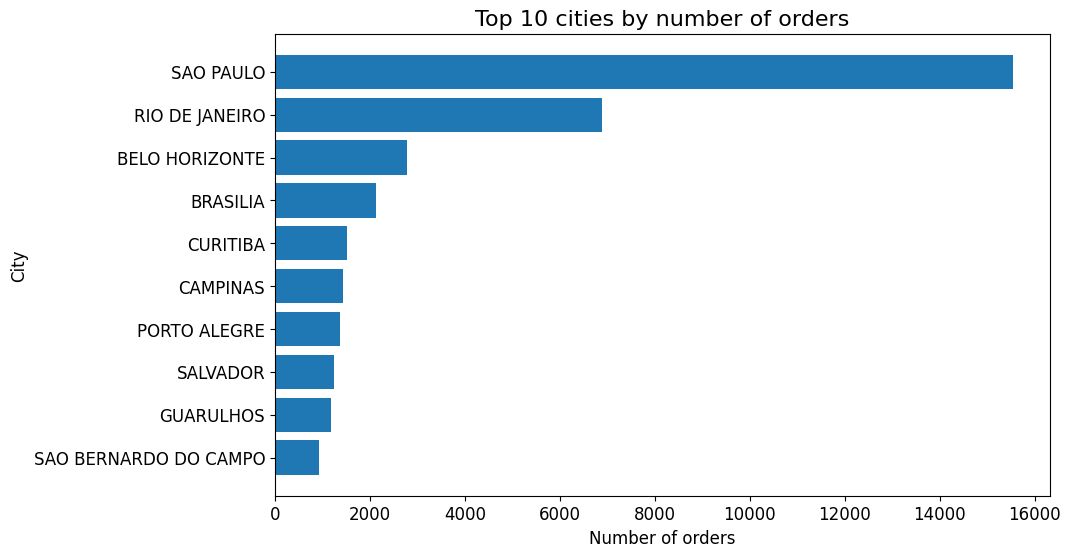

In [15]:
top_cities = pd.read_sql_query(orders_per_city_reversed, db_connection)

plt.figure(figsize=(10, 6))
plt.barh(top_cities['city'], top_cities['city_order_count'])
plt.xlabel('Number of orders')
plt.ylabel('City')
plt.title('Top 10 cities by number of orders')
plt.show()

As we can see, a lot more orders are placed in São Paulo and Rio de Janerio than in other cities, as you'd expect since these are also the largest cities in Brazil.  We'll take a closer look at the geographic distribution of orders later when we calculate customer lifetime value by zip code prefix.

<br>

# Order prices

What's the average value of an order? Does Olist handle transactions of items of really low or really high value? Before attempting to answer these questions, let's have a look at the **order_items** table. The table contains various ids and the price and shipping cost of the order's items. The currency is the brazilian real:

In [16]:
# Table order_items, first 4 columns
view_table('order_items', 5).iloc[:, :4]

,order_id,order_item_id,product_id,seller_id
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87


In [17]:
# Table order_items, last 2 columns
view_table('order_items', 5).iloc[:, 5:]

,price,freight_value
0,58.90,13.29
1,239.90,19.93
2,199.00,17.87
3,12.99,12.79
4,199.90,18.14


Let's answer our first question then: What's the average order price, considering both the cost of products and shipping? To start, let's find the orders with the lowest and the highest costs:

In [18]:
order_price_stats = """
SELECT
    MIN(order_price) AS min_order_price,
    ROUND(AVG(order_price), 2) AS avg_order_price,
    MAX(order_price) AS max_order_price
FROM (
    SELECT
        orders.order_id,
        SUM(order_items.price + order_items.freight_value) AS order_price
    FROM orders
        JOIN order_items USING (order_id)
    GROUP BY orders.order_id
)
"""

pd.read_sql_query(order_price_stats, db_connection)

,min_order_price,avg_order_price,max_order_price
0,9.59,160.58,13664.08


The average order price is 160.58 BRL, which is around the cost of a pair of sports shoes in 2017 in Brazil. As we can see, the most expensive order is 13664.08, almost 100 times the average, meaning we probably have a right-tailed distribution, where most of the orders have low cost but there are orders with a very high cost. Let's see the variation in prices, this time separating product cost and shipping cost. To start, let's aggregate the product cost and shipping cost for each order:

In [19]:
order_product_and_shipping_costs = """
SELECT
    orders.order_id,
    SUM(price) AS product_cost,
    SUM(freight_value) AS shipping_cost
FROM
    orders
    JOIN order_items USING (order_id)
WHERE order_status = 'delivered'
GROUP BY orders.order_id
"""

df = pd.read_sql_query(order_product_and_shipping_costs, db_connection)
df

,order_id,product_cost,shipping_cost
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14
...,...,...,...
96473,fffc94f6ce00a00581880bf54a75a037,299.99,43.41
96474,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53
96475,fffce4705a9662cd70adb13d4a31832d,99.90,16.95
96476,fffe18544ffabc95dfada21779c9644f,55.99,8.72


Let's plot a histogram of each cost. Since the cost can take a huge range of values but most orders have a low cost, I'll limit each plot's x-axes to 500 reals and 80 reals respectively to highlight the distribution of the most common values:

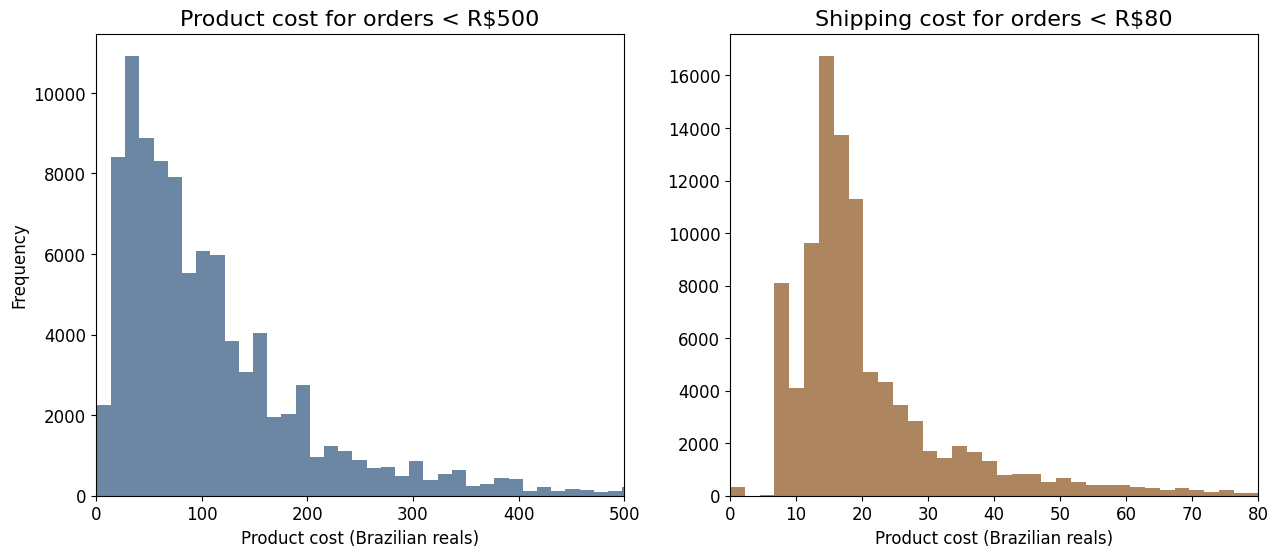

In [20]:
plt.figure(figsize=(15, 6))
# Histogram for total product cost
plt.subplot(1, 2, 1)
plt.hist(df['product_cost'], bins=1000, color='#6c87a3')
plt.title('Product cost for orders < R$500')
plt.xlabel('Product cost (Brazilian reals)')
plt.ylabel('Frequency')
plt.xlim([0, 500])
# Histogram for total shipping cost
plt.subplot(1, 2, 2)
plt.hist(df['shipping_cost'], bins=800, color='#ad865f')
plt.title('Shipping cost for orders < R$80')
plt.xlabel('Product cost (Brazilian reals)')
plt.xlim([0, 80])
plt.show()

The value of products in an order can vary wildly and take from very low to very high values, although most orders contain products with a total cost under 200 reals.

Shipping cost is usually between 7-20 reals, and rarely below that, but it can also take a wide range of much higher values.

<br>

# Product categories

Let's examine Olist's product categories by volume of sales. We'll start by looking at the *products* table, which contains 9 columns, but we'll only analyze product category and product weight:

In [21]:
view_table('products', 5).iloc[:, [0, 1, 5]]

,product_id,product_category_name,product_weight_g
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,225.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1000.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,154.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,371.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,625.0


There are 71 unique product categories. We can use a treemap to plot the relative sales of each category using areas. Since it will be challenging to visualize 71 categories, I'll choose the top 18 and group the rest into 'Other categories'. To start, let's get the total sales for each category. We'll also use the **product_category_name_translation** table which contains the category names in English:

In [22]:
ranked_categories = """
SELECT
    product_category_name_english AS category,
    SUM(price) AS sales,
    RANK() OVER (ORDER BY SUM(price) DESC) AS rank
FROM order_items
    JOIN orders USING (order_id)
    JOIN products USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE order_status = 'delivered'
GROUP BY product_category_name_english
"""

pd.read_sql_query(ranked_categories, db_connection)

,category,sales,rank
0,health_beauty,1233131.72,1
1,watches_gifts,1166176.98,2
2,bed_bath_table,1023434.76,3
3,sports_leisure,954852.55,4
4,computers_accessories,888724.61,5
...,...,...,...
66,flowers,1110.04,67
67,home_comfort_2,760.27,68
68,cds_dvds_musicals,730.00,69
69,fashion_childrens_clothes,519.95,70


Now we'll use the previous query as a CTE, and we'll use the *rank* column to take the first 18th categories by sales and aggregate the rest. UNION ALL merges the two subqueries, making sure that 'Other categories' will appear at the end of the result set:

In [23]:
category_sales_summary = f"""
WITH RankedCategories AS (
    {ranked_categories}
)
-- Top 18 categories by sales
SELECT
    category,
    sales
FROM RankedCategories
WHERE rank <= 18
-- Other categories, aggregated
UNION ALL
SELECT
    'Other categories' AS category,
    SUM(sales) AS sales
FROM RankedCategories
WHERE rank > 18
"""

df = pd.read_sql_query(category_sales_summary, db_connection)
df

,category,sales
0,health_beauty,1233131.72
1,watches_gifts,1166176.98
2,bed_bath_table,1023434.76
3,sports_leisure,954852.55
4,computers_accessories,888724.61
5,furniture_decor,711927.69
6,housewares,615628.69
7,cool_stuff,610204.10
8,auto,578966.65
9,toys,471286.48


Let's visualize this data using a treemap built with `squarify`:

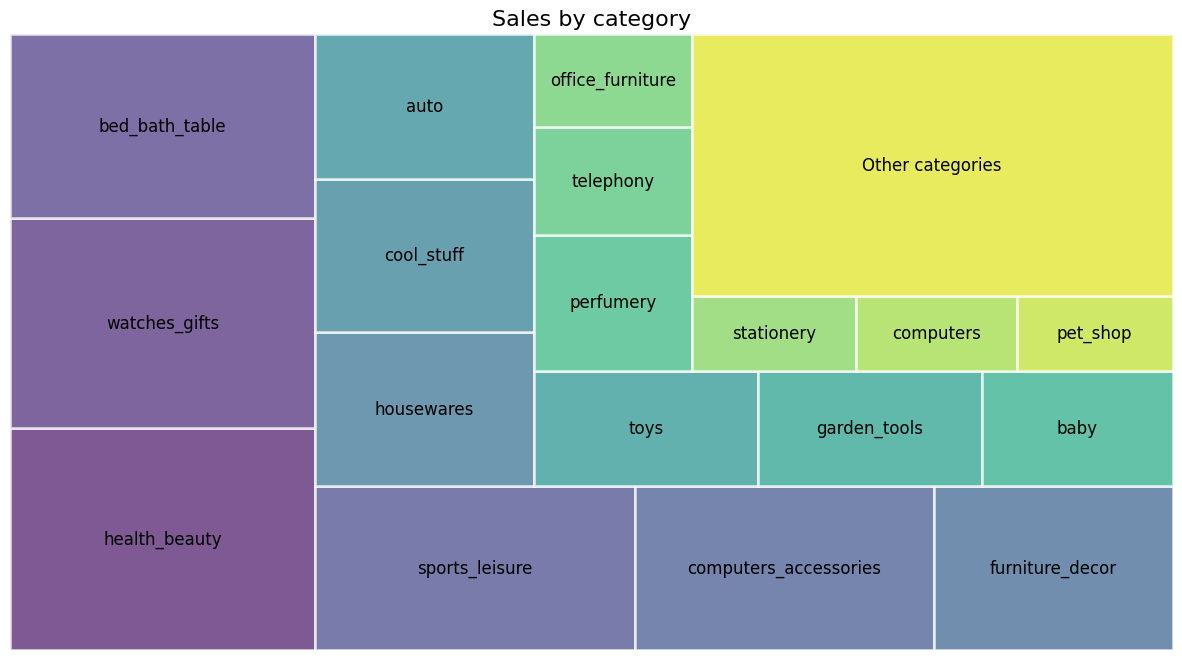

In [24]:
import squarify 

plt.figure(figsize=(15, 8))
plt.title('Sales by category')
color = sns.color_palette("viridis", len(df))
squarify.plot(sizes=df['sales'], label=df['category'],
              alpha=0.7, color=color, edgecolor="white", linewidth=2)
plt.axis('off')
plt.show()

We can gain more insight into the types of products these categories contain by visualizing the distribution of product weight by category using a set of box plots. To build the query for the weight of each product, we'll reuse the list of categories from the previous dataframe:

In [25]:
top_18_categories = tuple(category for category in df['category'] if category != 'Other categories')

It would be helpful to sort the boxes using the median of each category. We could easily calculate the medians in Python, although in the spirit of this challenge, let's do it using SQL. Unfortunately, SQLite doesn't have a function to calculate the median for each category, so we'll sort the products in each category using row numbers, and we'll also add the count of products for each category. We'll save the resulting dataframe to use it as the data source for the plot:

In [26]:
ordered_categories = f"""
SELECT
    product_weight_g AS weight,
    product_category_name_english AS category,
    ROW_NUMBER() OVER(PARTITION BY product_category_name_english ORDER BY product_weight_g)
        AS category_row_n,
    COUNT(*) OVER(PARTITION BY product_category_name_english) AS category_count
FROM
    products
    JOIN order_items USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE
    product_category_name_english IN {top_18_categories}
"""

df = pd.read_sql_query(ordered_categories, db_connection)
df

,weight,category,category_row_n,category_count
0,50.0,auto,1,4235
1,50.0,auto,2,4235
2,50.0,auto,3,4235
3,50.0,auto,4,4235
4,50.0,auto,5,4235
...,...,...,...,...
92419,15267.0,watches_gifts,5987,5991
92420,15267.0,watches_gifts,5988,5991
92421,15267.0,watches_gifts,5989,5991
92422,17175.0,watches_gifts,5990,5991


We can build on the previous query string `ordered_categories` to calculate the median for each category and return them sorted by medians:

In [ ]:
categories_by_median = f"""
WITH OrderedCategories AS (
    {ordered_categories}
)
SELECT category
FROM OrderedCategories
WHERE
    -- Odd number of products: Select the middle row
    (category_count % 2 = 1 AND category_row_n = (category_count + 1) / 2) OR
    -- Even number of products: Select the two middle rows to be averaged
    (category_count % 2 = 0 AND category_row_n IN ((category_count / 2), (category_count / 2 + 1)))
GROUP BY category
ORDER BY AVG(weight)
"""

categories_by_median_df = pd.read_sql_query(categories_by_median, db_connection)
categories_by_median_df

Now we can build the box plots, using the result of the previous query to order them:

In [ ]:
plt.figure(figsize=(12, 8))
order = categories_by_median_df['category'].tolist()
sns.boxplot(x='weight', y='category', data=df, order=order, showfliers=False)
plt.xlabel('Product weight (grams)')
plt.ylabel('Product category')
plt.title('Product weight by category (top 18 categories by sales)')
plt.xlim(-100, 26100)
plt.xticks(ticks=range(0, 30000, 2500))
plt.yticks(fontsize=14)
plt.show()

As we can see at the top of the plot, there are five categories whose items are mostly under 2 Kg: 'telephony', 'computers_accessories', 'watches_gifts', 'health_beauty'. At the bottom, we can see two categories, 'computers' and 'office_furniture', that include much heavier products.

<br>

# Sales prediction

We'll continue by examining the sales trends of a few handpicked categories:

In [ ]:
selected_categories = ('health_beauty', 'auto', 'toys', 'electronics', 'fashion_shoes')

To build a line plot of monthly sales for each category, we'll need a matrix of the sum of sales where columns are categories and rows are months:

In [ ]:
monthly_sales_selected_categories = f"""
SELECT 
    strftime('%Y-%m', order_purchase_timestamp) AS year_month,
    SUM(CASE WHEN product_category_name_english = 'health_beauty' THEN price END) AS health_beauty,
    SUM(CASE WHEN product_category_name_english = 'auto' THEN price END) AS auto,
    SUM(CASE WHEN product_category_name_english = 'toys' THEN price END) AS toys,
    SUM(CASE WHEN product_category_name_english = 'electronics' THEN price END) AS electronics,
    SUM(CASE WHEN product_category_name_english = 'fashion_shoes' THEN price END) AS fashion_shoes
FROM orders
    JOIN order_items USING (order_id)
    JOIN products USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE order_purchase_timestamp >= '2017-01-01'
    AND product_category_name_english IN {selected_categories}
GROUP BY year_month
"""

df = pd.read_sql_query(monthly_sales_selected_categories, db_connection)
df = df.set_index('year_month')
df

There's little data before 2017-01-01, so I ignored the few orders made before that time. Let's plot the time series:

In [ ]:
df.index = pd.to_datetime(df.index)
fig, ax = plt.subplots(figsize=(14, 8))
df.plot(ax=ax, marker='o', linestyle='-')
ax.set_xticks(df.index)
ax.set_xticklabels(df.index.strftime('%Y-%m'), rotation=90)
plt.title('Monthly sales for the selected categories')
plt.xlabel('Year-Month')
plt.ylabel('Monthly sales (Brazilian reals)')
plt.xticks(rotation=45)
plt.legend(title='Product category', title_fontsize=14, fontsize=14)
plt.grid(True)
plt.show()

As you can see, I picked these categories because they are diverse and each shows a unique trend. At the bottom, in purple there's 'fashion_shoes' which has the lowest-performing sales of the five categories and seems stagnant; across the whole period covered by the dataset, this category hovers around 1000–1500 reals of sales per month. The categories 'electronics' (red), 'auto' (green) and 'health_beauty' (blue), all seem to grow linearly at different rates. The category 'toys' peeks around the holidays, almost tripling in sales on november and december, but quickly goes back to its baseline after that period.

<br>

## Linear regression

Can we use linear regression to forecast sales for the next holiday season using only SQL? Of course! To achieve this, first we need to get the data we need to calculate the regression line for each category: days, the independent variable, that should be in numeric format, so we'll count the days that have passed since 2017-01-01; and total sales per day and category. The resulting query is:

In [ ]:
daily_sales_per_category = f"""
SELECT
    DATE(order_purchase_timestamp) AS date,
    -- Days since 2017-01-01
    CAST(JULIANDAY(order_purchase_timestamp) - JULIANDAY('2017-01-01') AS INTEGER) AS day,
    product_category_name_english AS category,
    SUM(price) AS sales
FROM
    orders
    JOIN order_items USING (order_id)
    JOIN products USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE
    order_purchase_timestamp BETWEEN '2017-01-01' AND '2018-08-29'
    AND category IN {selected_categories}
GROUP BY
    day,
    product_category_name_english
"""

pd.read_sql_query(daily_sales_per_category, db_connection)

We can use the previous query as a CTE, from which we can calculate the slope and intercept of the regression line for each category using the least squares method. The formula to calculate the slope is:

$$ slope = \frac{n \sum(\text{day} \cdot \text{sales}) - (\sum \text{day})(\sum \text{sales})}{n \sum(\text{day}^2) - (\sum \text{day})^2} $$

And the intercept is:

$$ intercept = \frac{\sum \text{sales} - slope \cdot (\sum \text{day})}{n} $$

Where $n$ is the count of rows per category:

In [ ]:
lm_per_category = f"""
WITH DailySalesPerCategory AS (
    {daily_sales_per_category}
)
SELECT
    category,
    -- Slope
    (COUNT(*) * SUM(day * sales) - SUM(day) * SUM(sales)) / 
        (COUNT(*) * SUM(day * day) - SUM(day) * SUM(day))
        AS slope,
    -- Intercept
    (SUM(sales) -
        ((COUNT(*) * SUM(day * sales) - SUM(day) * SUM(sales)) / 
        (COUNT(*) * SUM(day * day) - SUM(day) * SUM(day))) *
        SUM(day)) / COUNT(*)
        AS intercept
FROM
    DailySalesPerCategory
GROUP BY
    category
"""

df = pd.read_sql_query(lm_per_category, db_connection)
df

Let's see the regression lines for each category:

In [ ]:
import numpy as np

plt.figure(figsize=(14, 8))
days = np.arange(0, 604)
for category in selected_categories:
    lm = df[df['category'] == category]
    slope = lm['slope'].values[0]
    intercept = lm['intercept'].values[0]
    line = intercept + slope * days
    plt.plot(days, line, label=f'{category} (slope={slope:.2f})')
plt.title('Regression lines for the selected categories')
plt.xlabel('Days from 2017-01-01')
plt.ylabel('Daily sales (Brazilian reals)')
plt.legend(title='Product category', title_fontsize=14, fontsize=14)
plt.grid(True)
plt.show()

If we assume the trends in the regression lines for each category will continue in the following months, we can use them to forecast daily sales. To calculate the predicted sales for each day in december 2018 I will multiply the increase in sales from december 2017 to december 2018 with the sales of each day of december 2017:

$$
sales_{day + 365} = \frac{intercept + slope \cdot (day + 365)}{intercept + slope \cdot day} \cdot sales_{day}
$$

We can see the previous formula in the ForecastedSales CTE. In the main query, I will use the daily forecasts to calculate the 5-day moving average, to remove noise due to daily fluctuations in sales:

In [ ]:
forecasted_sales_dec_2018 = f"""
WITH DailySalesPerCategory AS (
    {daily_sales_per_category}
),
LmPerCategory AS (
    {lm_per_category}
),
ForecastedSales AS (
    SELECT
        DATE(date, '+1 year') AS date,
        category,
        -- Increase in predicted sales * sales 1 year ago
        (intercept + slope * (day + CAST(JULIANDAY('2018-12-31') - JULIANDAY('2017-12-31') AS INTEGER)))
            / (intercept + slope * day) * sales
            AS forecasted_sales
    FROM DailySalesPerCategory
        JOIN LmPerCategory USING (category)
    -- Filter for days of December 2018
    WHERE day + CAST(JULIANDAY('2018-12-31') - JULIANDAY('2017-12-31') AS INTEGER)
        BETWEEN CAST(JULIANDAY('2018-12-01') - JULIANDAY('2017-01-01') AS INTEGER)
        AND CAST(JULIANDAY('2018-12-31') - JULIANDAY('2017-01-01') AS INTEGER)
)
SELECT
    CAST(strftime('%d', date) AS INTEGER) AS december_2018_day,
    category,
    -- 5-day moving average
    AVG(forecasted_sales)
        OVER (PARTITION BY category ORDER BY date ROWS BETWEEN 2 PRECEDING AND 2 FOLLOWING)
        AS moving_avg_sales
FROM ForecastedSales
"""

forecast_2018_12_df = pd.read_sql_query(forecasted_sales_dec_2018, db_connection)
forecast_2018_12_df

In the next plot, we can see the predicted sales for december 2018 for each category:

In [ ]:
plt.figure(figsize=(15, 8))
for category in selected_categories:
    category_forecast = forecast_2018_12_df[forecast_2018_12_df['category'] == category]
    plt.plot(category_forecast['december_2018_day'], category_forecast['moving_avg_sales'], '--', label=category)
plt.title('Sales forecast for december 2018')
plt.xlabel('Days of december 2018')
plt.ylabel('Forecasted sales (Brazilian reals)')
plt.legend(title='Product category', title_fontsize=14, fontsize=14)
plt.grid(True)
plt.xticks(range(1, 32))
plt.show()

Our model predicts that *health_beauty* will be the highest selling category of the five we examined, and its sales will slowly go down until Christmas. *toys* will have strong sales for the first two weeks but decline sharply after that. *auto* sales remain stable for the first 3 weeks, but they'll go down afterward. *electronics* follows a similar trend but *fashion_shoes* sales seem to be independent of the holiday trends, increasing slightly at the end of the month.

<br>

# Order delivery

As we saw at the start of this notebook, the **orders** table contains various timestamps:
- *order_purchase_timestamp*: The order is placed by the customer.
- *order_approved_at*: The order is approved by Olist.
- *order_delivered_carrier_date*: The order is handed to the shipping company.
- *order_delivered_customer_date*: The customer receives the order.
- *order_estimated_delivery_date*: Delivery date estimation.

Each of these timestamps marks a change in the order shipping process. Let's query the data necessary to visualize the average time for each stage of the order process, for each of the top 10 cities with the most orders, which we saw earlier:

In [ ]:
order_stage_times_top_10_citites = f"""
SELECT 
    UPPER(customer_city)
        AS city,
    AVG(JULIANDAY(order_approved_at) - JULIANDAY(order_purchase_timestamp))
        AS approved,
    AVG(JULIANDAY(order_delivered_carrier_date) - JULIANDAY(order_approved_at))
        AS delivered_to_carrier,
    AVG(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_delivered_carrier_date))
        AS delivered_to_customer,
    AVG(JULIANDAY(order_estimated_delivery_date) - JULIANDAY(order_delivered_customer_date))
        AS estimated_delivery
FROM orders
    JOIN customers USING (customer_id)
WHERE  customer_city IN {tuple(top_cities['customer_city'])}
GROUP BY  customer_city
ORDER BY approved + delivered_to_carrier + delivered_to_customer DESC
"""

df = pd.read_sql_query(order_stage_times_top_10_citites, db_connection)
df = df.set_index('city')
df

Let's visualize the dataframe as a stacked bar plot:

In [ ]:
fig, ax = plt.subplots(figsize=(11, 7))
df.plot(kind='barh', stacked=True, color=['#c44f53', '#4c72b1', '#55a968', '#dd845275'], ax=ax)
ax.set_xlabel('Average days')
ax.set_ylabel('City')
fig.suptitle('Average days for each order stage (top 10 cities by sales)', fontsize=16, x=0.38, y=0.92)
ax.grid(True, linestyle='--', linewidth=0.5, axis='x')
max_bar_length = int(df.sum(axis=1).max())
ax.set_xticks(range(0, max_bar_length + 4))
ax.tick_params(axis='y', labelsize=14)
plt.legend(title='Order stage', title_fontsize=14, fontsize=14)
plt.show()

As we can see, the time it takes from the order is approved until it is dispatched to the carrier is similar in most cities, about 3 days. By contrast, the time the order takes to get to the customer varies wildly between cities: São Paulo, Guarulhos and São Bernardo do Campo display the same average shipping time of 5 days, while for cities at the bottom of the plot such as Rio de Janeiro, Porto Alegre and Salvador, orders take more than twice as much to get from the carrier to the customer on average. We can also observe that the average estimated delivery dates are at least a week later than the actual delivery, which tells us that these are not accurate predictions but rather pessimistic estimations.

Is there a seasonal variation in shipping times? To answer this question, we can create a line plot of daily average shipping time. I'll select orders from the period from june 2017 to june 2018:

In [ ]:
daily_avg_shipping_time = """
SELECT
    DATE(order_purchase_timestamp) AS purchase_date,
    AVG(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp))
        AS avg_delivery_time
FROM orders
WHERE order_purchase_timestamp >= '2017-06-01' AND order_purchase_timestamp <= '2018-06-30'
GROUP BY DATE(order_purchase_timestamp)
"""

df = pd.read_sql_query(daily_avg_shipping_time, db_connection)
df

Let's plot the time series, with a red line showing the global average shipping time during the period:

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(pd.to_datetime(df['purchase_date']), df['avg_delivery_time'], label='Daily average')
plt.axhline(y=df['avg_delivery_time'].mean(), color='r', linestyle='--', label='Yearly average')
plt.ylabel('Days')
plt.title('Average delivery time (from June 2017 to June 2018)')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.legend()
plt.show()

As we can see, there are two periods where shipping times are significantly higher than average: December 2017 and February-March 2018. The delays on december are probably caused by the busy holiday season, but the delays February-March could be due to the [postal strikes](https://www.riotimesonline.com/brazil-news/rio-business/brazilian-postal-workers-remain-on-strike-in-rio-and-sao-paulo/) that happened in certain states of Brazil at the time.

# Order reviews

Our database also includes an **order_reviews** table. Users can score an order from 1 to 5 and write a comment on the order. Let's see the columns we'll use in our analysis:

In [ ]:
view_table('order_reviews', 5).iloc[:, [1, 2, 4]]

Let's count how many orders there are for each review score:

In [ ]:
review_score_count = """
SELECT
    review_score,
    COUNT(*) AS count
FROM order_reviews
GROUP BY review_score
"""
df = pd.read_sql_query(review_score_count, db_connection)
df

In [ ]:
plt.figure(figsize=(10,6))
colors = ['#BC2023', '#EB442C', '#F8B324', '#6da814', '#0C6B37']
sns.barplot(x='review_score', y='count', data=df, hue='review_score', palette=colors, dodge=False)
plt.title('Distribution of review scores')
plt.xlabel('Review score')
plt.ylabel('Count')
plt.legend().remove()
plt.tight_layout()
plt.show()


We can see that most review scores are very positive, but there's also a fair number of unsatisfied customers. What's the cause? To answer this question, let's create a word cloud of the comments with a score of 1 or 2. First we'll need to concatenate all messages using the GROUP_CONCAT function:

In [ ]:
negative_comments = """
SELECT GROUP_CONCAT(review_comment_message, ' ') AS comments
FROM order_reviews
WHERE review_score IN (1,2)
"""

negative_comments_df = pd.read_sql(negative_comments, db_connection)['comments'][0]
negative_comments_df[:150]

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(negative_comments_df)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

If you know some Brazilian, you'll see that the main cause of negative comments is related to shipping delays. Dissatisfaction with the product quality or other order errors seem to be secondary.

<br>

# Customer segmentation

Can we use SQL for customer segmentation? Absolutely! We can use a simple segmentation method such as RFM, which groups customers according to three metrics:
- **Recency**: How recently did the customer place the last order?
- **Frequency**: How often does the customer place orders?
- **Monetary value**: How much does the customer spend on average?

Afterward, each customer is assigned to a category according to its RFM scores. This segmentation process is particularly useful for personalized marketing or to improve customer service by addressing the specific needs of different customer groups.

The following SQL query is a bit longer than the previous but not too complex. I'll break it down in 3 steps:
1. Calculate each of the three RFM scores in three CTEs using the NTILE function, which ranks each customer from 1-5 in the given score. 
2. Assign each customer to one of 11 groups, using the method outlined in this [article by Mark Rittman](https://www.rittmananalytics.com/blog/2021/6/20/rfm-analysis-and-customer-segmentation-using-looker-dbt-and-google-bigquery).
3. Calculate statistics for each group, so we can plot them by sales, recency and size.

In [ ]:
rfm_buckets = """
-- 1. Calculate RFM scores
WITH RecencyScore AS (
    SELECT customer_unique_id,
           MAX(order_purchase_timestamp) AS last_purchase,
           NTILE(5) OVER (ORDER BY MAX(order_purchase_timestamp) DESC) AS recency
    FROM orders
        JOIN customers USING (customer_id)
    WHERE order_status = 'delivered'
    GROUP BY customer_unique_id
),
FrequencyScore AS (
    SELECT customer_unique_id,
           COUNT(order_id) AS total_orders,
           NTILE(5) OVER (ORDER BY COUNT(order_id) DESC) AS frequency
    FROM orders
        JOIN customers USING (customer_id)
    WHERE order_status = 'delivered'
    GROUP BY customer_unique_id
),
MonetaryScore AS (
    SELECT customer_unique_id,
           SUM(price) AS total_spent,
           NTILE(5) OVER (ORDER BY SUM(price) DESC) AS monetary
    FROM orders
        JOIN order_items USING (order_id)
        JOIN customers USING (customer_id)
    WHERE order_status = 'delivered'
    GROUP BY customer_unique_id
),

-- 2. Assign each customer to a group
RFM AS (
    SELECT last_purchase, total_orders, total_spent,
        CASE
            WHEN recency = 1 AND frequency + monetary IN (1, 2, 3, 4) THEN "Champions"
            WHEN recency IN (4, 5) AND frequency + monetary IN (1, 2) THEN "Can't Lose Them"
            WHEN recency IN (4, 5) AND frequency + monetary IN (3, 4, 5, 6) THEN "Hibernating"
            WHEN recency IN (4, 5) AND frequency + monetary IN (7, 8, 9, 10) THEN "Lost"
            WHEN recency IN (2, 3) AND frequency + monetary IN (1, 2, 3, 4) THEN "Loyal Customers"
            WHEN recency = 3 AND frequency + monetary IN (5, 6) THEN "Needs Attention"
            WHEN recency = 1 AND frequency + monetary IN (7, 8) THEN "Recent Users"
            WHEN recency = 1 AND frequency + monetary IN (5, 6) OR
                recency = 2 AND frequency + monetary IN (5, 6, 7, 8) THEN "Potentital Loyalists"
            WHEN recency = 1 AND frequency + monetary IN (9, 10) THEN "Price Sensitive"
            WHEN recency = 2 AND frequency + monetary IN (9, 10) THEN "Promising"
            WHEN recency = 3 AND frequency + monetary IN (7, 8, 9, 10) THEN "About to Sleep"
        END AS RFM_Bucket
    FROM RecencyScore
        JOIN FrequencyScore USING (customer_unique_id)
        JOIN MonetaryScore USING (customer_unique_id)
)

-- 3. Calculate group statistics for plotting
SELECT RFM_Bucket, 
       AVG(JULIANDAY('now') - JULIANDAY(last_purchase)) AS avg_days_since_purchase, 
       AVG(total_spent / total_orders) AS avg_sales_per_customer,
       COUNT(*) AS customer_count
FROM RFM
GROUP BY RFM_Bucket
"""

df = pd.read_sql(rfm_buckets, db_connection)
df

Let's visualize this. I'll plot each group using average recency on the x-axis, average sales per customer on the y-axis and circle size to represent the amount of customers in each group:

In [ ]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['avg_days_since_purchase'], df['avg_sales_per_customer'],
    s=df['customer_count']*0.55, c=sns.color_palette('Set3', len(df)))
plt.xlabel('Average days since the last purchase', fontsize=14)
plt.ylabel('Average sales per customer', fontsize=14)
plt.title('RFM segmentation of customers')
plt.grid(True)
for i, text in enumerate(df['RFM_Bucket']):
    plt.annotate(text, (df['avg_days_since_purchase'][i], df['avg_sales_per_customer'][i]), 
        ha='center', va='center')
plt.gca().invert_xaxis()
plt.xlim(2530, 2070)
plt.ylim(0, 380)
plt.show()

The previous plot shows us where each customer segment falls in terms of recency and sales. For example, the 'Champions' segment on the top right has high sales and has purchased recently, while the 'Lost' segment on the opposite side has low sales and no recent purchases.

Let's build a plot of the proportion of one-time customers vs repeat customers to gain more insight into how loyal are people who buy through Olist:

In [ ]:
repeat_customer_proportion = """
WITH CustomerOrders AS (
    SELECT COUNT(orders.order_id) AS order_count
    FROM orders JOIN customers USING (customer_id)
    GROUP BY customers.customer_unique_id
)
SELECT
    CASE WHEN order_count > 1 THEN 'repeat' ELSE 'one-time' END AS order_type,
    ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM CustomerOrders), 1) AS proportion
FROM CustomerOrders
GROUP BY order_type
"""

df = pd.read_sql_query(repeat_customer_proportion, db_connection)
df

In [ ]:
fig, ax = plt.subplots()
ax.pie(df['proportion'], labels=df['order_type'], startangle=5)
ax.set_title('Proportion of one-time vs repeat customers')
fig.set_facecolor('white')
plt.show()

As we can see most customers only place a single order through Olist.

<br>

# Customer lifetime value

Customer Lifetime Value (CLV) is a crucial metric in business that measures the predicted value of the future relationship with a customer. Let's calculate CLV for the customers in our dataset. To achieve this, we'll introduce a new table **order_payments**, which contains payments made and payment methods used:

In [ ]:
view_table('order_payments', 5)

To start, we'll calculate each of the components of CLV for each client:
- Purchase Frequency (PF), the number of orders a client placed.
- Average Order Value (AOV), the sum of payments divided by the number of orders.
- Average Customer Lifespan (ACL), the number of weeks from the first to the last order, with a minimum value of 1.

To make the code more readable, I'll use a CTE to gather the necessary data, then in the main query I'll calculate each of the CLV components:

In [ ]:
clv = """
WITH CustomerData AS (
    SELECT
        customer_unique_id,
        customer_zip_code_prefix AS zip_code_prefix,
        COUNT(DISTINCT orders.order_id) AS order_count,
        SUM(payment_value) AS total_payment,
        JULIANDAY(MIN(order_purchase_timestamp)) AS first_order_day,
        JULIANDAY(MAX(order_purchase_timestamp)) AS last_order_day
    FROM customers
        JOIN orders USING (customer_id)
        JOIN order_payments USING (order_id)
    GROUP BY customer_unique_id
)
SELECT
    customer_unique_id,
    zip_code_prefix,
    order_count AS PF,
    total_payment / order_count AS AOV,
    CASE
        WHEN (last_order_day - first_order_day) < 7 THEN
            1
        ELSE
            (last_order_day - first_order_day) / 7
        END AS ACL
FROM CustomerData
"""

pd.read_sql(clv, db_connection)

Since my goal is to build a map of the distribution of CLV around Brazil, we'll also need to add the latitude and longitude of each zip code prefix, which can be found in the table **geolocation**:

In [ ]:
view_table('geolocation', 5)

Using the previous query as CTE, we can calculate the average CLV and the number of customers for each zip code prefix. To calculate CLV we just multiply each of its terms:

$$ CLV = PF \cdot AOV \cdot ACL $$

In [ ]:
avg_clv_per_zip_prefix = f"""
WITH CLV AS (
    {clv}
)
SELECT
    zip_code_prefix AS zip_prefix,
    AVG(PF * AOV * ACL) AS avg_CLV,
    COUNT(customer_unique_id) AS customer_count,
    geolocation_lat AS latitude,
    geolocation_lng AS longitude
FROM CLV
    JOIN geolocation ON CLV.zip_code_prefix = geolocation.geolocation_zip_code_prefix
GROUP BY zip_code_prefix
"""

df = pd.read_sql(avg_clv_per_zip_prefix, db_connection)
df

With these data we can create an interactive map using the `folium` library. For each zip code prefix a circle is drawn in the map, using opacity to indicate CLV and size to indicate the number of customers:

In [ ]:
import folium

map = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)
for i, zip_prefix in df.iterrows():
    folium.CircleMarker(
        location=[zip_prefix['latitude'], zip_prefix['longitude']],
        radius=0.1*np.sqrt(zip_prefix['customer_count']),
        color=None,
        fill_color='#85001d',
        fill_opacity=0.1+0.1*np.sqrt(zip_prefix['avg_CLV']/df['avg_CLV'].max()),
        popup=(
            f"<b>Zip Code Prefix:</b> {int(zip_prefix['zip_prefix'])}<br>"
            f"<b>Average CLV:</b> {int(zip_prefix['avg_CLV'])}<br>"
            f"<b>Customers:</b> {int(zip_prefix['customer_count'])}"
        )
    ).add_to(map)
map

As we can see in the map, most of the customer value for Olist's sellers is concentrated in the south-east of Brazil, in the most populated areas: the state of São Paulo, and around the cities of Rio de Janeiro and Belo Horizonte.

<br>

# Product affinity

What products are usually bought together? Unfortunately, product names are removed from the Olist dataset due to privacy concerns, but we still have information about the product's categories. Let's get the data necessary to build a graph of the products that appear frequently in the same order. First of all, we'll get a list of products that appear in more than 5 orders:

In [ ]:
min_orders = 5

most_ordered_products = f"""
SELECT
    products.product_id,
    product_category_name_english AS category,
    COUNT(order_id) AS orders_count
FROM order_items
    JOIN products USING (product_id)
    JOIN product_category_name_translation AS tr
        ON products.product_category_name = tr.product_category_name
GROUP BY products.product_id
    HAVING COUNT(order_id) > {min_orders}
"""

most_ordered_products_df = pd.read_sql(most_ordered_products, db_connection)
most_ordered_products_df

We also need to get information about the relationships between products. We can count the number of orders each pair of products appears on using a self-join for combinations of products in the same order and grouping them by product:

In [ ]:
most_ordered_product_ids = tuple(most_ordered_products_df['product_id'])

products_often_ordered_together = f"""
SELECT
    oi1.product_id AS product_id1,
    oi2.product_id AS product_id2,
    COUNT(DISTINCT oi1.order_id) AS common_orders_count
FROM order_items AS oi1
    JOIN order_items AS oi2
        ON oi1.order_id = oi2.order_id -- Same order
        AND oi1.product_id < oi2.product_id -- Avoid permutations
WHERE
    oi1.product_id IN {most_ordered_product_ids} AND
    oi2.product_id IN {most_ordered_product_ids}
GROUP BY
    oi1.product_id,
    oi2.product_id
    HAVING COUNT(DISTINCT oi1.order_id) > {min_orders}
"""

products_often_ordered_together_df = pd.read_sql(products_often_ordered_together, db_connection)
products_often_ordered_together_df

With these two sets of data, we can build the graph of products frequently bought together:

In [ ]:
import networkx as nx

G = nx.Graph()
# Add nodes to the graph
for _, product in most_ordered_products_df.iterrows():
    G.add_node(product['product_id'], category=product['category'], orders_count=product['orders_count'])
# Add edges to the graph
for _, pair in products_often_ordered_together_df.iterrows():
    G.add_edge(pair['product_id1'], pair['product_id2'], weight=pair['common_orders_count'])
# Remove nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))
# Assign colors to categories
categories = list(set(nx.get_node_attributes(G, 'category').values()))
colors = plt.cm.rainbow(np.linspace(0, 1, len(categories)))
category_colors = dict(zip(categories, colors))
# Draw the graph
plt.figure(figsize=(12, 8))
position = nx.spring_layout(G, k=0.5, iterations=50)
node_sizes = [G.nodes[n]['orders_count'] * 5 for n in G.nodes]
node_colors = [category_colors[G.nodes[n]['category']] for n in G.nodes]
nx.draw_networkx(G, position, node_color=node_colors, node_size=node_sizes, alpha=0.6, with_labels=False)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=category, markerfacecolor=color, markersize=15)
                   for category, color in category_colors.items()]
plt.legend(handles=legend_elements, title="Product category", loc='upper left', title_fontsize=14)
plt.tight_layout()
plt.show()

In the graph each circle represents a product and its color indicates the product category it belongs to. A line between two products indicates that they are often bought together as part of the same order. The circle's size indicates product importance, how many orders in the whole dataset contain this product.

There are 5 products in the *Garden tools* category that are often bought together. There's also a product from the *Bed, Bath, Table* category that is often bought together with another from the *Home confort* category. We can also observe that some products in the *Auto* and *Computer accessories* categories are also often bought with other items of the same category.

<br>

# Sellers

The table **sellers** contains 3095 sellers that use Olist's services. Let's have a look at the first few rows:

In [ ]:
view_table('sellers', 5)

Are most sellers small, with a few sales, or large companies with a high volume of sales? How do review scores vary among the different sellers? We can answer both of those questions using a scatterplot. Let's get the data we need from the **sellers** table:

In [ ]:
seller_review_scores_and_sales = '''
SELECT 
    sellers.seller_id,
    AVG(order_reviews.review_score) AS avg_review_score,
    SUM(order_items.price) AS total_sales,
    COUNT(orders.order_id) AS num_orders
FROM 
    sellers
    LEFT JOIN order_items ON sellers.seller_id = order_items.seller_id
    LEFT JOIN orders ON order_items.order_id = orders.order_id
    LEFT JOIN order_reviews ON orders.order_id = order_reviews.order_id
GROUP BY 
    sellers.seller_id
HAVING 
    COUNT(orders.order_id) > 10
'''

df = pd.read_sql_query(seller_review_scores_and_sales, db_connection)
df

We'll create a scatterplot where each point is a seller, the y-axis indicates its average order review score, the x-axis shows total sales, using a logarithmic scale, since most sellers have very low sales. We'll also use both color and size to represent the number of orders:

In [ ]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df, x='total_sales', y='avg_review_score', size='num_orders', sizes=(10, 500), 
                hue='num_orders', palette='flare', alpha=0.7)
plt.xscale('log')
plt.xlabel('Total sales (logarithmic scale)')
plt.ylabel('Average review score')
plt.title('Sellers: Review score vs Sales')
plt.legend(title='Number of Orders')
plt.show()

As we can see, most of Olist's sellers are small, with just a few orders. As you'd expect, larger sellers have less variance in their average order review scores, with most sellers being in the range between 3.5 and 4.5. Notice in the group of large sellers at the right of the plot, there's a seller with significantly lower scores than its peers. We can also observe that there are sellers with the same amount of total sales but significantly different numbers of orders (bubbles with different sizes in the same x position), meaning that some sellers have significantly higher average order value than others.

Let's build another plot to help us understand the distribution of sellers by order size. We'll sort the sellers into 4 groups according to the number of orders they dispatched:
- Group 1: Sellers with 1-9 orders.
- Group 2: Sellers with 10-99 orders.
- Group 3: Sellers with 100-199 orders.
- Group 4: Sellers with 1000 or more orders.

In [ ]:
bucketed_sellers = """
SELECT
    seller_id,
    CASE 
        WHEN COUNT(order_id) BETWEEN 1 AND 9 THEN '1-9 orders'
        WHEN COUNT(order_id) BETWEEN 10 AND 99 THEN '10-99 orders'
        WHEN COUNT(order_id) BETWEEN 100 AND 999 THEN '100-999 orders'
        ELSE '1000+ orders'
    END AS bucket
FROM order_items
GROUP BY seller_id
"""

pd.read_sql_query(bucketed_sellers, db_connection).head(5)

In [ ]:
sellers_per_bucket = f"""
WITH BucketedSellers AS (
    {bucketed_sellers}
)
SELECT 
    bucket,
    COUNT(seller_id) AS seller_count
FROM BucketedSellers
GROUP BY bucket
"""

seller_buckets = pd.read_sql_query(sellers_per_bucket, db_connection)
seller_buckets

Let's visualize the dataframe:

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x='bucket', y='seller_count', data=seller_buckets, hue='bucket', palette='flare', dodge=False)
plt.title('Number of sellers by orders (grouped)')
plt.xlabel('Amount of orders per seller')
plt.ylabel('Number of sellers')
plt.tight_layout()
plt.show()

We can verify most sellers are small, with very few having more than 1000 orders.

Do larger sellers have lower shipping times? To answer this question let's build a plot of the distribution of shipping time for each of the previous four groups. We'll reuse the previous CTE in the query to get the data we need:

In [ ]:
seller_shipping_times = f"""
WITH BucketedSellers AS (
    {bucketed_sellers}
)
SELECT
    bucket,
    BucketedSellers.seller_id,
    JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp)
        AS delivery_time
FROM orders
    JOIN order_items USING (order_id)
    JOIN BucketedSellers USING (seller_id)
WHERE order_status = 'delivered'
"""

df = pd.read_sql_query(seller_shipping_times, db_connection)
df

Let's draw four boxplots, corresponding to each bar in the previous plot:

In [ ]:
plt.figure(figsize=(12, 8))
palette = sns.color_palette('flare', len(seller_buckets['bucket']))
sns.boxplot(x='bucket', y='delivery_time', data=df, order=seller_buckets['bucket'], showfliers=False,
            hue='bucket', palette=palette[1:]+palette[:1], dodge=False)
plt.title('Delivery time by seller order volume')
plt.xlabel('Sellers with...')
plt.ylabel('Shipping time (days)')
plt.legend().remove() 
plt.show()

Somehow, the larger the seller is, the longer deliveries tend to take. What causes this increase in shipping times? Do smaller sellers take less time between order approval and handing the package to the shipping company? I leave it to the reader to explore the dataset and find the answer to this question.

<br>

# Lead conversion

To end this exploration of the Olist database, let's have a look at the two remaining tables. First, we have **leads_qualified**, which contains a list of sellers that filled in the contact request form on Olist's website, filtered by the sales team (thus becoming "qualified"):

In [ ]:
view_table('leads_qualified', 5)

The second table, **leads_closed** contains information on which of the previous sellers joined Olist's platform. This table contains many columns, and we won't look at them in depth here, but let's see some of them:

In [ ]:
view_table('leads_closed', 5).iloc[:, [0,3,4,5]]

We'll build a plot of the number of leads per *origin* and how many of them signed up to Olist. The *origin* field of the **leads_qualified** table contains the origin category 'unknown' but also some null values, which we'll add to the 'unknown' group using the COALESCE function:

In [ ]:
lead_conversion = """
SELECT 
    COALESCE(origin, 'unknown') AS origin,
    COUNT(DISTINCT leads_qualified.mql_id) AS qualified_leads,
    COUNT(DISTINCT leads_closed.mql_id) AS closed_leads,
    COUNT(DISTINCT leads_closed.mql_id) * 100.0 / COUNT(DISTINCT leads_qualified.mql_id)
        AS conversion_rate
FROM leads_qualified
    LEFT JOIN leads_closed USING (mql_id)
GROUP BY COALESCE(origin, 'unknown')
ORDER BY COUNT(leads_qualified.mql_id) DESC
"""

df = pd.read_sql_query(lead_conversion, db_connection)
df

Let's visualize the data using a grouped bar plot:

In [ ]:
plt.figure(figsize=(12, 8))
bar_width = 0.4
r1 = range(len(df))
r2 = [x + bar_width for x in r1]
plt.bar(r1, df['qualified_leads'], color='#e24a33', width=bar_width, label='Qualified leads')
plt.bar(r2, df['closed_leads'], color='#348abe', width=bar_width, label='Closed leads')
for i, v in enumerate(df['qualified_leads']):
    plt.text(i, v + 20, str(v), ha='center', fontsize=10)
for i, v in enumerate(df['closed_leads']):
    plt.text(i + bar_width, v + 20, str(v), ha='center', fontsize=10)
plt.xlabel('Origin')
plt.ylabel('Number of potential sellers')
plt.title('Leads by origin')
plt.xticks([r + bar_width / 2 for r in range(len(df))], df['origin'],
           rotation=45, color='black', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

As we can see, only a small proportion of qualified leads end up becoming Olist sellers. The largest sources of closed leads are 'organic_search' and 'paid_search', followed by leads of unknown origin. Let's build a plot of the conversion rate to see more clearly which channels are the most effective at bringing in sellers:

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(df['origin'], df['conversion_rate'], color='#1c8a4f')
plt.ylabel('Conversion rate (%)')
plt.title('Lead conversion rate by origin')
plt.xticks(rotation=45, color='black', fontsize=12)
plt.tight_layout()
plt.show()

In the plot, we can see the proportion of leads that become Olist sellers by channel of origin, in the same order as the previous grouped bar plot.

We can see that, while 'paid_search', 'organic_search' and 'direct_traffic' have the best conversion rate, other channels such as 'email', 'social', 'display' and 'other_publicities' have lower rates of conversion.

<br>

# Conclusion

As we have seen, even though SQL is primarily designed for managing and querying data within a database, it's still capable of handling all data manipulation tasks typically performed by general-purpose programming languages. While using SQL for data manipulation can make queries more efficient, reducing the workload on the database, this might not always be the best choice in practice. For instance, the section on sales forecasting using linear regression contains lengthy queries that could be streamlined using Python's libraries, which simplify the entire process into just a few lines of code. We can get the best of both worlds when we use Python to generate repetitive lines of SQL code, store CTEs in variables to be reused in multiple queries or store lists of values obtained from one query to filter subsequent queries.

In our exploration of the Olist dataset, we have uncovered several insights into the company’s operations. We observed that Olist experienced steady growth over the period covered by the dataset, with a significant increase in sales around Christmas. Sales trends showed that certain product categories are growing much faster than others. Purchasing patterns indicate that customers are more likely to place orders at the start of the week. The bulk of sales is concentrated in populous cities, particularly São Paulo and Rio de Janeiro. Shipping durations vary significantly across different cities and are sometimes affected by postal strikes. Despite many positive reviews, there are frequent complaints about shipping delays. Most orders are of low value, though there is considerable variation in the costs of orders. The most popular product category is "Health and Beauty". The dataset includes very few repeat customers. There some products that are frequently bought together, especially in the categories "Garden Tools" and "Computer Accessories". Most of Olist’s sellers are small businesses, and these generally have slightly faster shipping times than larger sellers. The key channels for acquiring sellers for Olist include organic search, paid search, and direct traffic.

Despite all we've learned about the Olist dataset, we have barely scratched  the surface. Don't hesitate to leave a comment on the notebook for any question you have whether it's related to SQL, the methods I used or to the database. For any business inquiries you can reach me through Kaggle messages or [LinkedIn](https://www.linkedin.com/in/terenci/). Thank you to Olist for generously providing the data used in this project. 

Upvote this notebook to help others discover it!

<br>